#### 1. load and preprocess data

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

# print out examples
%matplotlib inline

set up paths

In [2]:
import os
# base directories
base_dir = './archive/afhq'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# directory with training animal pictures
train_cat_dir = os.path.join(train_dir, 'cat')
train_dog_dir = os.path.join(train_dir, 'dog')
train_wild_dir = os.path.join(train_dir, 'wild')

# directory with validation cat/dog pictures
val_cat_dir = os.path.join(val_dir, 'cat')
val_dog_dir = os.path.join(val_dir, 'dog')
val_wild_dir = os.path.join(val_dir, 'wild')

print("Contents of base directory:")
print(os.listdir(base_dir))
print("\nContents of train directory:")
print(os.listdir(train_dir))
print("\nContents of validation directory:")
print(os.listdir(val_dir))

Contents of base directory:
['train', 'val']

Contents of train directory:
['cat', 'dog', 'wild']

Contents of validation directory:
['cat', 'dog', 'wild']


read data

In [3]:
# define parameters
train_len = 4738
val_len = 500
N_train = 3 * train_len
N_val = 3 * val_len
# resize image to 150*159
D = 150 * 150

X_train = np.zeros((D, N_train))
X_val = np.zeros((D, N_val))

# read image from file
count = 0
for folder in os.listdir(train_dir):
    path = os.path.join(train_dir, folder)
    for fn in os.listdir(path):
        image = cv2.imread(os.path.join(path, fn), cv2.IMREAD_GRAYSCALE)
        resized = cv2.resize(image, (150, 150))
        X_train[:, count] = resized.reshape(D)
        count += 1

count = 0
for folder in os.listdir(val_dir):
    path = os.path.join(val_dir, folder)
    for fn in os.listdir(path):
        image = cv2.imread(os.path.join(path, fn), cv2.IMREAD_GRAYSCALE)
        resized = cv2.resize(image, (150, 150))
        X_val[:, count] = resized.reshape(D)
        count += 1

In [4]:
print(X_train.shape)
print(X_val.shape)

(22500, 14214)
(22500, 1500)


In [5]:
X_data = np.concatenate((X_train.T, X_val.T), axis=0)
print(X_data.shape)

(15714, 22500)


In [6]:
# create label vectors Y: 0-cat, 1-cow, 2-dog, 3-horse, 4-sheep
Y_train = np.asarray([0]*train_len + [1]*train_len + [2]*train_len).T
Y_val = np.asarray([0]*val_len + [1]*val_len + [2]*val_len).T

print(Y_train.shape)
print(Y_val.shape)

(14214,)
(1500,)


In [7]:
Y_data = np.concatenate((Y_train, Y_val), axis=0)
print(Y_data.shape)

(15714,)


#### 2. clustering

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
from numpy import random

2.0 dimensionality reduction

In [9]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X_data)

In [10]:
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X_norm)
print(X_pca.shape)

(15714, 100)


In [ ]:
# pca2 = PCA(n_components=2)
# X_pca2 = pca2.fit_transform(X_norm)
# print(X_pca2.shape)

##### 2.1. self built

In [9]:
def init_em(k, dim):
    mu = random.rand(k, dim) * 20 - 10
    sigma = np.zeros((k, dim, dim))
    for i in range(k):
        sigma[i] = np.eye(dim)
    # mu = np.asmatrix(random.random((k, dim))) * 20 - 10
    # sigma = np.array([np.asmatrix(np.identity(dim)) for i in range(k)])
    pi = np.ones(k)/k
    return mu, sigma, pi

In [20]:
def e_step(X, k, mu, sigma, pi):
    gamma = np.zeros((X.shape[0], k))
    for i in range(k):
        gamma[:, i] = pi[i] * multivariate_normal.pdf(X, mu, sigma)
    return gamma / gamma.sum(axis=1, keepdims=True)

In [21]:
def m_step(X, k, mu, sigma, pi, gamma):
    sum_gamma = gamma.sum(axis=0)
    pi = sum_gamma / X.shape[0]
    mu = np.matmul(gamma.T, X)
    mu = mu / sum_gamma[:, None]
    for i in range(k):
        j = np.expand_dims(X, axis=1) - mu[i]
        s = np.matmul(j.transpose([0, 2, 1]), j)
        sigma[i] = np.matmul(s.transpose(1, 2, 0), gamma[:, i] )
        sigma[i] /= sum_gamma[i]
    return mu, sigma, pi

In [12]:
def log_likelihood(X, k, mu, sigma, pi):
    '''
    Compute the log-likelihood of X under current parameters
    input:
        - X: Data (batch_size, dim)
    output:
        - log-likelihood of X: Sum_n log (Sum_k (pi_k * N( X_n | mu_k, sigma_k)) )
    '''
    llh = []
    for d in X:
        p_x = 0
        for i in range(k):
            p_x += pi[i] * multivariate_normal.pdf(d, mean=mu[i], cov=sigma[i])
        llh.append(np.log(p_x))
    return np.sum(llh)

In [34]:
def fit(X, k, max_iters=20, tol=1e-4):
    # Algorithm will run unti max of log-likelihood is achieved
    mu, sigma, pi = init_em(k, X.shape[1])
    # Saving log-likelihood
    llh = [log_likelihood(X, k, mu, sigma, pi)]
    for e in range(max_iters):
        gamma = e_step(X, k, mu, sigma, pi)
        mu, sigma, pi = m_step(X, k, mu, sigma, pi, gamma)
        llh.append(log_likelihood(X, k, mu, sigma, pi))
        print('Iteration %d: log-likelihood is %.6f'%(e, llh[-1]))
    print('Terminate at %d-th iteration:log-likelihood is %.6f'%(e, llh[-1]))
    return llh

In [65]:
import scipy.stats as sp

class GaussianMixModel(object):
    def __init__(self, X, k=2):
        # Algorithm can work for any number of columns in dataset
        X = np.asarray(X)
        self.m, self.n = X.shape
        self.data = X.copy()
        print (np.mean(X))
        # number of mixtures
        self.k = k

    def _init(self):
        # init mixture means/sigmas
        self.mean_arr = np.asmatrix(np.random.random((self.k, self.n))+np.mean(self.data))
        #self.mean_arr[0]=0;
        #self.mean_arr[1]=25;
        self.sigma_arr = np.array([np.asmatrix(np.identity(self.n)) for i in range(self.k)])
        self.phi = np.ones(self.k)/self.k
        self.Z = np.asmatrix(np.empty((self.m, self.k), dtype=float))
        #Z Latent Variable giving probability of each point for each distribution

    def fit(self, tol=1e-4):
        # Algorithm will run unti max of log-likelihood is achieved
        self._init()
        num_iters = 0
        logl = 1
        previous_logl = 0
        while(logl-previous_logl > tol):
            previous_logl = self.loglikelihood()
            self.e_step()
            self.m_step()
            num_iters += 1
            logl = self.loglikelihood()
            print('Iteration %d: log-likelihood is %.6f'%(num_iters, logl))
        print('Terminate at %d-th iteration:log-likelihood is %.6f'%(num_iters, logl))

    def loglikelihood(self):
        logl = 0
        for i in range(self.m):
            tmp = 0
            for j in range(self.k):
                #print(self.sigma_arr[j])
                tmp += sp.multivariate_normal.pdf(self.data[i, :],self.mean_arr[j, :].A1,self.sigma_arr[j, :]) * self.phi[j]
            logl += np.log(tmp)
        return logl

    def e_step(self):
        #Finding probability of each point belonging to each pdf and putting it in latent variable Z
        for i in range(self.m):
            den = 0
            for j in range(self.k):
                #print (self.data[i, :])
                num = sp.multivariate_normal.pdf(self.data[i, :],
                                                       self.mean_arr[j].A1,
                                                       self.sigma_arr[j]) *\
                      self.phi[j]
                den += num

                self.Z[i, j] = num
            self.Z[i, :] /= den
            # assert self.Z[i, :].sum() - 1 < 1e-4  # Program stop if this condition is false

    def m_step(self):
        #Updating mean and variance
        for j in range(self.k):
            const = self.Z[:, j].sum()
            self.phi[j] = 1/self.m * const
            _mu_j = np.zeros(self.n)
            _sigma_j = np.zeros((self.n, self.n))
            for i in range(self.m):
                _mu_j += (self.data[i, :] * self.Z[i, j])
                _sigma_j += self.Z[i, j] * ((self.data[i, :] - self.mean_arr[j, :]).T * (self.data[i, :] - self.mean_arr[j, :]))

            self.mean_arr[j] = _mu_j / const
            self.sigma_arr[j] = _sigma_j / const

In [79]:
import numpy as np
from numpy import random
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.stats import multivariate_normal

class GMM():
    def __init__(self, k, dim, init_mu=None, init_sigma=None, init_pi=None, colors=None):
        '''
        Define a model with known number of clusters and dimensions.
        input:
            - k: Number of Gaussian clusters
            - dim: Dimension 
            - init_mu: initial value of mean of clusters (k, dim)
                       (default) random from uniform[-10, 10]
            - init_sigma: initial value of covariance matrix of clusters (k, dim, dim)
                          (default) Identity matrix for each cluster
            - init_pi: initial value of cluster weights (k,)
                       (default) equal value to all cluster i.e. 1/k
            - colors: Color valu for plotting each cluster (k, 3)
                      (default) random from uniform[0, 1]
        '''
        self.k = k
        self.dim = dim
        if(init_mu is None):
            init_mu = random.rand(k, dim)*20 - 10
        self.mu = init_mu
        if(init_sigma is None):
            init_sigma = np.zeros((k, dim, dim))
            for i in range(k):
                init_sigma[i] = np.eye(dim)
        self.sigma = init_sigma
        if(init_pi is None):
            init_pi = np.ones(self.k)/self.k
        self.pi = init_pi
        if(colors is None):
            colors = random.rand(k, 3)
            for i in range(k):
                colors[i, 2] = i/k
        self.colors = colors
    
    def init_em(self, X):
        '''
        Initialization for EM algorithm.
        input:
            - X: data (batch_size, dim)
        '''
        self.data = X
        self.num_points = X.shape[0]
        self.z = np.zeros((self.num_points, self.k))
    
    def e_step(self):
        '''
        E-step of EM algorithm.
        '''
        for i in range(self.k):
            self.z[:, i] = self.pi[i] * multivariate_normal.pdf(self.data, mean=self.mu[i], cov=self.sigma[i])
        self.z /= self.z.sum(axis=1, keepdims=True)
    
    def m_step(self):
        '''
        M-step of EM algorithm.
        '''
        sum_z = self.z.sum(axis=0)
        self.pi = sum_z / self.num_points
        self.mu = np.matmul(self.z.T, self.data)
        self.mu /= sum_z[:, None]
        for i in range(self.k):
            j = np.expand_dims(self.data, axis=1) - self.mu[i]
            s = np.matmul(j.transpose([0, 2, 1]), j)
            self.sigma[i] = np.matmul(s.transpose(1, 2, 0), self.z[:, i] )
            self.sigma[i] /= sum_z[i]
            
    def log_likelihood(self, X):
        '''
        Compute the log-likelihood of X under current parameters
        input:
            - X: Data (batch_size, dim)
        output:
            - log-likelihood of X: Sum_n Sum_k log(pi_k * N( X_n | mu_k, sigma_k ))
        '''
        ll = []
        for d in X:
            tot = 0
            for i in range(self.k):
                tot += self.pi[i] * multivariate_normal.pdf(d, mean=self.mu[i], cov=self.sigma[i])
            ll.append(np.log(tot))
        return np.sum(ll)
    
    def plot_gaussian(self, mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):
        '''
        Utility function to plot one Gaussian from mean and covariance.
        '''
        pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0),
            width=ell_radius_x * 2,
            height=ell_radius_y * 2,
            facecolor=facecolor,
            **kwargs)
        scale_x = np.sqrt(cov[0, 0]) * n_std
        mean_x = mean[0]
        scale_y = np.sqrt(cov[1, 1]) * n_std
        mean_y = mean[1]
        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(mean_x, mean_y)
        ellipse.set_transform(transf + ax.transData)
        return ax.add_patch(ellipse)

    def draw(self, ax, n_std=2.0, facecolor='none', **kwargs):
        '''
        Function to draw the Gaussians.
        Note: Only for two-dimensionl dataset
        '''
        if(self.dim != 2):
            print("Drawing available only for 2D case.")
            return
        for i in range(self.k):
            self.plot_gaussian(self.mu[i], self.sigma[i], ax, n_std=n_std, edgecolor=self.colors[i], **kwargs)

In [71]:
def plot(title, X, gmm):
    '''
    Draw the data points and the fitted mixture model.
    input:
        - title: title of plot and name with which it will be saved.
    '''
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    ax.scatter(X[:, 0], X[:, 1], s=3, alpha=0.4)
    ax.scatter(gmm.mu[:, 0], gmm.mu[:, 1], c=gmm.colors)
    gmm.draw(ax, lw=3)
    ax.set_xlim((-22, 22))
    ax.set_ylim((-22, 22))
    
    plt.title(title)
    plt.savefig(title.replace(':', '_'))
    plt.show()
    plt.clf()

In [ ]:
X_pca2 = X_pca[:, :2]

gmm = GMM(3, 2)
gmm.init_em(X_pca2)
num_iters = 20
# Saving log-likelihood
llh = [gmm.log_likelihood(X_pca2)]
# plotting
# plot("Iteration:  0", X_pca2, gmm)
for e in range(num_iters):
    # E-step
    gmm.e_step()
    # M-step
    gmm.m_step()
    # Computing log-likelihood
    llh.append(gmm.log_likelihood(X_pca2))
    print("Iteration: {}, log-likelihood: {:.4f}".format(e+1, log_likelihood[-1]))
    # plotting
    # plot(title="Iteration: " + str(e+1), X_pca2, gmm)

##### 2.2. scikit-learn

In [11]:
# khởi tạo mô hình GaussianMixture
gm = GaussianMixture(n_components=3, covariance_type='full', random_state=0)
gm.fit(X_pca)
print('means: \n', gm.means_.shape)
print('covariances: \n ', gm.covariances_.shape)

means: 
 (3, 100)
covariances: 
  (3, 100, 100)


In [12]:
pred = gm.predict(X_pca)

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix

print(confusion_matrix(Y_data, pred))
print(accuracy_score(Y_data, pred))

[[3277 1625  336]
 [ 159 3544 1535]
 [ 572 1166 3500]]
0.6568028509609266


In [19]:
print(pred[:100])

[0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 2 0
 0 0 0 1 0 2 1 1 2 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1 2 0 0 0 1 0 0 0 0 0 1 1 1
 1 1 0 0 0 1 1 0 1 0 0 0 2 0 0 1 1 0 0 0 2 1 0 0 1 2]


In [83]:
# khởi tạo mô hình GaussianMixture
gm2 = GaussianMixture(n_components=3, covariance_type='full', random_state=0)
gm2.fit(X_pca2)
print('means: \n', gm2.means_)
print('covariances: \n ', gm2.covariances_)

means: 
 [[ 39.59527661 -10.43565315]
 [-33.75174076 -19.85839921]
 [ -6.4098302   43.14059763]]
covariances: 
  [[[3397.18588858  489.78183331]
  [ 489.78183331 2092.71722936]]

 [[2980.75763478 -424.42522109]
  [-424.42522109 1611.43770169]]

 [[2409.63496507 -184.36132766]
  [-184.36132766 2365.21974315]]]


In [86]:
pred2 = gm2.predict(X_pca2)

In [87]:
print(confusion_matrix(Y_data, pred2))
print(accuracy_score(Y_data, pred2))

[[1779 2210 1249]
 [1826 1920 1492]
 [1967 2623  648]]
0.2766323024054983


In [109]:
gm.covariances_[:, :2, :2].shape

(3, 2, 2)

visualize

In [35]:
import matplotlib as mpl

def make_ellipses(gm, ax):
    colors = ['turquoise', 'orange', 'green']
    for n, color in enumerate(colors):
        covariances = gm.covariances_[n, :2, :2]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 3. * np.sqrt(2.) * np.sqrt(v)
        mean=gm.means_[n]
        mean=mean.reshape(100,1)
        # print(mean)
        ell = mpl.patches.Ellipse(mean[:2], v[0], v[1], angle=180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

def plot_2D(gm,x):
    h = plt.subplot(111)
    
    plt.scatter(x[:,0],x[:,1],marker='x')
    plt.xlim(-200, 200)
    plt.ylim(-200, 200)
    # plt.xlabel(col[0])
    # plt.ylabel(col[1])
    make_ellipses(gm, h)
    #plot_cov_ellipse(gmm.sigma_arr[:,:,0],gmm.mean_arr[:,1],ax=ax[0,0])
    plt.show()

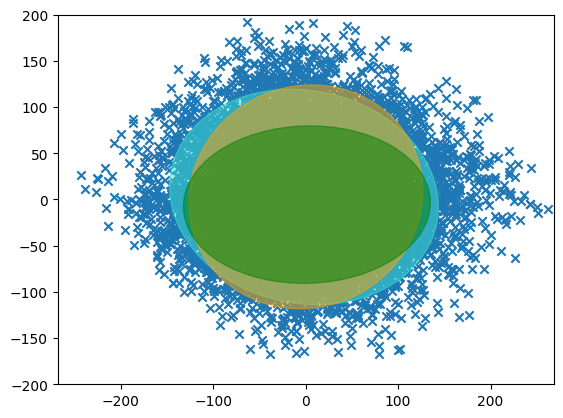

In [36]:
plot_2D(gm, X_pca)

In [24]:
import matplotlib as mpl

def plot_results(X, Y_, means, covariances, ax):
    colors = ['turquoise', 'orange', 'green']
    for i, (mean, covar, color) in enumerate(zip(means, covariances, colors)):
        v, w = np.linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

    # plt.xlim(-9.0, 5.0)
    # plt.ylim(-3.0, 6.0)
    plt.xlim(-200, 200)
    plt.ylim(-200, 200)
    plt.xticks(())
    plt.yticks(())

In [156]:
print(gm.bic(X_pca))
print(gm.aic(X_pca))

10902353.615658395
10783955.64304655


In [28]:
X_data[Y_data == 0].shape

(5238, 22500)

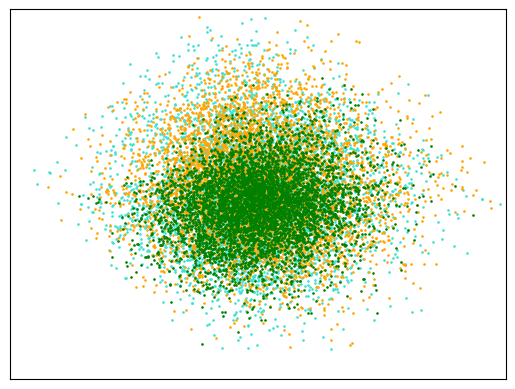

In [31]:
h = plt.subplot(111)
plot_results(X_pca, Y_data, gm.means_[:, 50:52], gm.covariances_[:, 50:52, 50:52], h)

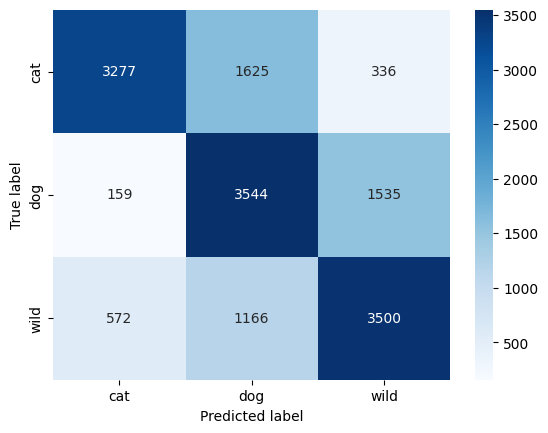

In [14]:
import seaborn as sns
cm = confusion_matrix(Y_data, pred)
labels = ['cat', 'dog', 'wild']
sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, cmap='Blues', fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [15]:
from sklearn.metrics import silhouette_score, adjusted_rand_score

print(adjusted_rand_score(Y_data, pred))

0.25334523566211503
